# Q-Learning from Scratch

Followed [this tutorial](http://mnemstudio.org/path-finding-q-learning-tutorial.htm) to build a simple Q-learning (reinforcement learning) algorithm. Able to take other reward matricies and even has a random graph generator (via `networkx`). Currently only allows for the edges contiguous to the goal node to have a reward (100). Additionally, all goal nodes loop back to themselves. After fitting (w/ `learn`), enter start node (must be integer, have to convert letters to integers) into `predict_path` to obtain optimal path.

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)

%matplotlib inline

In [2]:
class Q_learning:
    '''  Q-Learning Algorithm
    
    Utilizes Q-learning (reinforcement learning) to find optimal path given a graph with reward/weighted edges.
    Can take pre-made graphs or can produce randomly-generated ones. Currently, reward matrix has following attributes:
        -1 = no edge present
        0 = edge without reward (not connected to goal node)
        100 = edge with reward (connected to goal node)
    Fit with `learn` and find optimal path with `predict_path`
    
    Parameters
    ---
    gamma : float, [0,1], (default = 0.8)
            discount factor, trades off the importance of earlier versus later rewards,
            may also be interpreted as the probability to succeed (or survive) at every step.
    
    epochs : int, (default = 1000)
            number of iterations the algorithm runs and thus learns
            
    Attributes
    ---
    q_matrix_ : array, shape = reward.shape
            "algorithm's brain", matrix of different (state, action) Q-scores,
            higher scores correspond to optimal path for given state
    '''
    def __init__(self, gamma=0.8, epochs=1000):
        
        self.gamma = gamma
        self.epochs = epochs
    
    
    def random_graph(self, nodes=6, edges=8):
        '''
        Create random graph with n nodes and e edges. Every node has at least one connection,
        every edge is bi-directional, the final node is always treated as the goal state.
        
        Parameters
        ---
        nodes : int, (default = 6)
                number of nodes, must be less than or equal to the number of edges
                
        edges : int, (default = 8)
                number of edges, can be equal to or at most two times the number of nodes
                
        Attributes
        ---
        graph : nx.Graph.dense_gnm_random_graph object
                Randomly generated graph
                
        Return
        ---
        matrix : numpy array, shape = [nodes, nodes]
                Matrix representation of graph, w/ pre-stated reward attributes
        '''
        while True:
            self.graph = nx.dense_gnm_random_graph(nodes, edges)
            matrix = nx.to_numpy_array(self.graph)
            if 0 not in np.sum(matrix, axis=1):
                break
        
        matrix = matrix - 1
        matrix[:, -1][matrix[:, -1] == 0] = 100
        matrix[-1,-1] = 100
        
        return matrix
    
    
    def print_graph(self, matrix=None):
        '''
        Illustrates randomly-generated graph or pre-made reward matrix.
        
        Parameters
        ---
        matrix : array, (default = None)
                pre-made reward matrix, needs to be in pre-stated format (no edge = -1, edge w/o reward = 0)
        '''
        if np.any(matrix):
            matrix[matrix == 100] = 0
            matrix = matrix + 1
            nx.draw_networkx(nx.from_numpy_array(matrix))
        else:
            nx.draw_networkx(self.graph)
      
    
    def _actions(self, reward, state):
        '''
        Finds all possible actions for given state. (Helper function for the learn method)
        
        Parameters
        ---
        reward : array
                graph matrix w/ edges and corresponding rewards/weights
        
        state : int
                current state in graph/reward matrix
        
        Return
        ---
        (list) all possible actions
        '''
        return np.argwhere(reward[state] >= 0).ravel()
    
    
    def _q_score(self, reward, state, action):
        '''
        Calculate the Q-score for the given (state, action) pair (Helper function for the learn method)
            Q(state, action) = Reward(state, action) + gamma * max[Q(next_state, all actions)],
            where next_state = current action
            
        Parameters
        ---
        reward : array
                graph matrix w/ edges and corresponding rewards/weights
        
        state : int
                current state in graph/reward matrix
        
        action : int
                selected action, which will become next state
        
        Return
        ---
        (float) Q-score
        '''
        next_actions = self._actions(reward, action)
        return reward[state, action] + self.gamma*max([self.q_matrix_[action, a] for a in next_actions])
    
    
    def learn(self, reward, goal=None):
        '''
        Q-learning algorithm. Initializes Q-score matrix and updates during each iteration.
        At end, standardizes q_matrix_ by the maximum score [0-100]
        
        Parameters
        ---
        reward : array
                either pre-made reward matrix or randomly-generated one
                
        goal : int, (default = None)
                terminal/goal node, corresponds to the `goal`-th column in reward
                either user-given or simply assigned to the last node/column if not
        '''
        self.q_matrix_ = np.zeros(reward.shape)
        self.goal_ = goal
        
        if not self.goal_:
            self.goal_ = reward.shape[0] - 1
        
        for _ in range(self.epochs):

            state = random.randint(0, self.goal_)
            next_state = None

            while next_state != self.goal_:

                next_state = random.choice(self._actions(reward, state))
                q = self._q_score(reward, state, next_state)
                
                if q > self.q_matrix_[state, next_state]:
                    self.q_matrix_[state, next_state] = q
                    
                state = next_state
                
        self.q_matrix_ = self.q_matrix_ * (100 / np.amax(self.q_matrix_))
        
        
    def predict_path(self, start_node=0):
        '''
        Find the optimal path after learning the graph.
        Given a start node, use the Q-score-matrix to get to goal node. (Prints path)
        
        Parameters
        ---
        start_node : int, (default = 0)
                starting point, can be any node within graph
                
        Return
        ---
        path : list
                optimal path
        '''
        path = [start_node]
        state = start_node
        
        while state != self.goal_:
            options = np.argwhere(self.q_matrix_[state] == np.amax(self.q_matrix_[state])).ravel()
            state = random.choice(options)
            path.append(state)
        
        for i, node in enumerate(path):
            print(node, end=' ')
            if i < len(path)-1:
                print('-->', end=' ')
                
        return path  

### Example graph

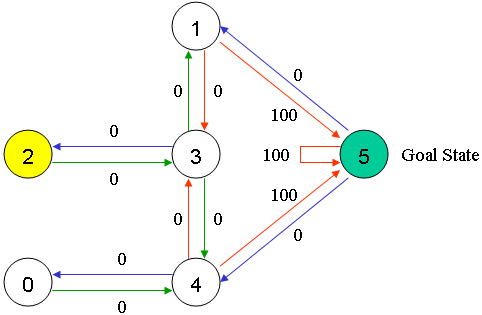

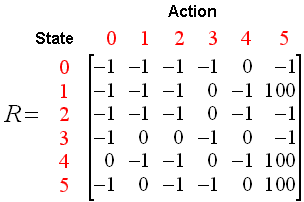

### Create example reward matrix
* -1 = no edge
* 0 = edge without reward
* 100 = edge connected to goal node

In [3]:
reward = -np.ones([6,6])
edges = [[0,4], [1,3], [2,3], [3,1], [3,2], [3,4], [4,0], [4,3], [5,1], [5,4]]
hundreds = [1,4,5]

for i, row in enumerate(reward):
    for j, val in enumerate(row):
        if [i,j] in edges:
            reward[i,j] = 0
        if j == 5 and i in hundreds:
            reward[i,j] = 100
            
print(reward)

[[ -1.  -1.  -1.  -1.   0.  -1.]
 [ -1.  -1.  -1.   0.  -1. 100.]
 [ -1.  -1.  -1.   0.  -1.  -1.]
 [ -1.   0.   0.  -1.   0.  -1.]
 [  0.  -1.  -1.   0.  -1. 100.]
 [ -1.   0.  -1.  -1.   0. 100.]]


### Learn the map/graph and find Q-matrix

In [4]:
q = Q_learning()
q.learn(reward)
print(q.q_matrix_)

[[  0.    0.    0.    0.   80.    0. ]
 [  0.    0.    0.   64.    0.  100. ]
 [  0.    0.    0.   64.    0.    0. ]
 [  0.   80.   51.2   0.   80.    0. ]
 [ 64.    0.    0.   64.    0.  100. ]
 [  0.   80.    0.    0.   80.  100. ]]


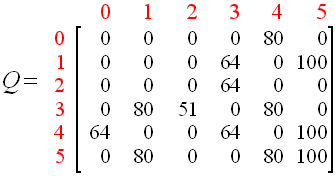

### Optimal path starting at node 2

In [5]:
path = q.predict_path(2)

2 --> 3 --> 4 --> 5 

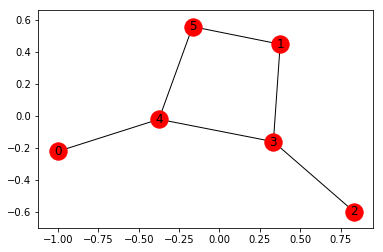

In [6]:
q.print_graph(reward)